# Navigation


1. [Intro](#Intro)

    1.1 [Description of Experiment](#Description-of-Experiment)
  
2. [Preprocessing](#Preprocessing)

    2.1 [Download and Read Data](#Download and Read Data)
    
    2.2 [Clean Variables Names](#Clean Variables Names)
    
    2.3 [Set Response Variable](#Set Response Variable)
    
    2.4 [Test and Train Datasets](#Test and Train Datasets)
    
    2.5 [Principal Components Analysis](#Principal Components Analysis)
    
3. [Data Visualisation](#Data Visualisation)

4. [Modeling](#Modeling)
    
    4.1 [k-NN](#k-NN)
    
    4.2 [Random Forest](#Random Forest)
    
    4.3 [Generalized Linear Model](#Generalized Linear Model)
    
5. [Conclusion](#Conclusion)

--------------------

<a name="Intro"></a>

# Intro

Human activity recognition has wide applications in healthcare, smart environments (like IoT), and many more.

The main goal of the following work is to build an activity recognition classifier, using acceleration data generated by a user’s cell phone. 

The Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living while carrying a waist-mounted smartphone with embedded inertial sensors.<sup>[1](#myfootnote1)</sup>

We will try to use different predictive algorithms, and test the models accuracy on an independent test set. 

<a name="Description-of-Experiment"></a>

## Description of Experiment

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities:

  - walking 
  - walking upstairs
  - walking downstairs
  - sitting
  - standind
  - laying 
  
The activities where performed while wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually.<sup>[2](#myfootnote1)</sup>

[![link to video](http://img.youtube.com/vi/XOEN9W05_4A/0.jpg "Experiment Image")](https://www.youtube.com/watch?v=XOEN9W05_4A)

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

The obtained data set, which consists of 562 features (explanatory variables) and the response, has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

--------

<a name="myfootnote1">1</a>: The data is available at the UC Irvine Machine Learning Repository [(link to data)](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

<a name="myfootnote1">2</a>: Follow 
[this link](https://www.youtube.com/watch?v=XOEN9W05_4A&feature=youtu.be) or simply click on the above image to see a video of the 6 activities recorded in the experiment with one of the participants. 


--------
<a name="Preprocessing"></a>

# Preprocessing

In this section we will load the data into R and perform a data cleaning process in order to generate a tidy datasets. We then use Principal Components Analysis (PCA) in order to reduce the number of explanatory variables.

The two data sets will be used later on for data analysis, model fitting and model evaluation.

The original data containing the following files:

  - activity_labels.txt
  - features_info.txt
  - features.txt
  - README.txt
  - test:
      * subject_test.txt
      * X_test.txt
      * y_test.txt
      * Inertial Signals
  * train:
      * subject_train.txt
      * X_train.txt
      * y_train.txt
      * Inertial Signals
      
We will use this data to create two tidy data sets, train and test (out of the original data and the PCA data). As mentioned, the training set will contain 70% of the data, and the test set will contain the raimaning 30%.

<a name="Download and Read Data"></a>

## Download and Read Data

First, let us load the relevent R libraries

------------------

In [2]:
# markdown visualisation
library(knitr) # kable makes tables (DF/DT) prettier

# data manipulation
library(data.table)
library(dplyr)

# visualisation
library(ggplot2)
library(scatterplot3d)

# Modeling
library(randomForest)
library(glmnet)
library(caret)
library(class)

We now download a zip file containing the dataset (if it is not already exists locally):

In [4]:
# url to dataset at the UC Irvine Machine Learning Repository
data.url <- paste("https://archive.ics.uci.edu/ml/machine-learning-databases",
                  "/00240/UCI%20HAR%20Dataset.zip", sep = '')
file.name <- "UCI HAR Dataset.zip" 
  
# download dataset if it is not already exists locally
if(!(file.exists(file.name))){
    download.file(data.url, destfile = file.name, method = "auto")        
}

We now unzip the file and read the relevent datasets:

In [3]:
# unzip if not alredy unzipped
unzipped.file <- "UCI HAR Dataset"
if(!(file.exists(unzipped.file))){
    unzip(file.name)
}

# read datasets
# variables names
var.names <- fread(paste(unzipped.file, "/features.txt", sep = ''), 
                        header = FALSE, col.names = c("id", "name"))
# activity labels
activity.labels <- fread(paste(unzipped.file, "/activity_labels.txt", sep = ''), 
                        header = FALSE, col.names = c("id", "name"))
# train data
X.train <- fread(paste(unzipped.file, "/train/X_train.txt", sep = ''), 
                        header = FALSE)
y.train <- fread(paste(unzipped.file, "/train/y_train.txt", sep = ''), 
                        header = FALSE, col.names = "activity")
subject.train <- fread(paste(unzipped.file, "/train/subject_train.txt", sep = ''), 
                        header = FALSE)
# test data
X.test <- fread(paste(unzipped.file, "/test/X_test.txt", sep = ''), 
                        header = FALSE)
y.test <- fread(paste(unzipped.file, "/test/y_test.txt", sep = ''), 
                        header = FALSE, col.names = "activity")
subject.test <- fread(paste(unzipped.file, "/test/subject_test.txt", sep = ''), 
                        header = FALSE)

cat("Training data is consists of", dim(X.train)[2], "explanatory variables, and", 
    dim(X.train)[1], "observations.\nTest data is consists of", dim(X.test)[2], 
    "explanatory variables, and", dim(X.test)[1], "observations.")

Training data is consists of 561 explanatory variables, and 7352 observations.
Test data is consists of 561 explanatory variables, and 2947 observations.

<a name="Clean Variables Names"></a>

## Clean Variables Names

Let us look at the first 6 variable names:


In [6]:
kable(var.names[1:6,])



| id|name              |
|--:|:-----------------|
|  1|tBodyAcc-mean()-X |
|  2|tBodyAcc-mean()-Y |
|  3|tBodyAcc-mean()-Z |
|  4|tBodyAcc-std()-X  |
|  5|tBodyAcc-std()-Y  |
|  6|tBodyAcc-std()-Z  |


We can see that there is variables with syntactically invalid names. In addition, there are some variables with same name (even though the variables are not identical):

In [14]:
cat("There are", length(var.names$name), "variables, but only", 
    n_distinct(var.names$name), "unique variable names.")

There are 561 variables, but only 477 unique variable names.

We will make variable names valid, and unique.

In [4]:
v.names <- var.names$name

# remove '()-,'
v.names <- gsub("\\()", "", v.names)
v.names <- gsub("-", "", v.names)
v.names <- gsub(",", "", v.names)

# make names unique
v.names <- make.names(v.names, unique = TRUE)
# new names
kable(data.table('before' = var.names$name[1:6], 'after' = v.names[1:6]))



|before            |after         |
|:-----------------|:-------------|
|tBodyAcc-mean()-X |tBodyAccmeanX |
|tBodyAcc-mean()-Y |tBodyAccmeanY |
|tBodyAcc-mean()-Z |tBodyAccmeanZ |
|tBodyAcc-std()-X  |tBodyAccstdX  |
|tBodyAcc-std()-Y  |tBodyAccstdY  |
|tBodyAcc-std()-Z  |tBodyAccstdZ  |


Much better. Let us varify that all variables names are unique:

In [9]:
cat("There are", length(v.names), "variables, and", 
    n_distinct(v.names), "unique variable names.")

There are 561 variables, and 561 unique variable names.

All good.

<a name="Set Response Variable"></a>

## Set Response Variable

Next, we will change the response's (y) levels:


In [5]:
# change to factor
y.train.vec <- factor(y.train$activity)
y.test.vec <- factor(y.test$activity)
# change levels
levels(y.train.vec) <- activity.labels$name
levels(y.test.vec) <- activity.labels$name

<a name="Test and Train Datasets"></a>

## Test and Train Datasets

Now, we are ready to build our training and test sets:

In [6]:
train <- cbind(subject.train, X.train, y.train.vec)
colnames(train) <- c('Subject', v.names, 'Activity')

# first five rows of sample of columns from train dataset
print("Train")
kable(train[1:5, c(1:5, 563), with = F])

test <- cbind(subject.test, X.test, y.test.vec)
colnames(test) <- c('Subject', v.names, 'Activity')

# first five rows of sample of columns from test dataset
print("Test")
kable(test[1:5, c(1:5, 563), with = F])

[1] "Train"


| Subject| tBodyAccmeanX| tBodyAccmeanY| tBodyAccmeanZ| tBodyAccstdX|Activity |
|-------:|-------------:|-------------:|-------------:|------------:|:--------|
|       1|     0.2885845|    -0.0202942|    -0.1329051|   -0.9952786|STANDING |
|       1|     0.2784188|    -0.0164106|    -0.1235202|   -0.9982453|STANDING |
|       1|     0.2796531|    -0.0194672|    -0.1134617|   -0.9953796|STANDING |
|       1|     0.2791739|    -0.0262006|    -0.1232826|   -0.9960915|STANDING |
|       1|     0.2766288|    -0.0165697|    -0.1153618|   -0.9981386|STANDING |
[1] "Test"


| Subject| tBodyAccmeanX| tBodyAccmeanY| tBodyAccmeanZ| tBodyAccstdX|Activity |
|-------:|-------------:|-------------:|-------------:|------------:|:--------|
|       2|     0.2571778|    -0.0232852|    -0.0146538|   -0.9384040|STANDING |
|       2|     0.2860267|    -0.0131634|    -0.1190825|   -0.9754147|STANDING |
|       2|     0.2754848|    -0.0260504|    -0.1181517|   -0.9938190|STANDING |
|       2|   

Let us now check for missing data in our complete data sets:

In [14]:
cat("There are", sum(colSums(is.na(train))), "missing values in the train set, and",
                    sum(colSums(is.na(test))), "in the test set.")

There are 0 missing values in the train set, and 0 in the test set.

We can see that there are no missing values in both datasets.

Lastly, we will export the tidy datasets to CSV.

In [15]:
write.csv(train, 'HAR_train.csv', row.names = FALSE)
write.csv(test, 'HAR_test.csv', row.names = FALSE)

<a id="Principal Components Analysis"></a>

## Principal Components Analysis

Principal component analysis (PCA) is a dimensionality reduction technique that is widely used in data analysis. Reducing the dimensionality of a dataset can be useful in different ways. For example,lower dimension data can significantly reduce the computational time of some algorithms. In addition, many statistical models suffer from high correlation between covariates, or curse of dimensionality, and PCA can be used to produce linear combinations of the covariates that are uncorrelated between each other.

We will first apply PCA to the training set only, and then predict the corrosponding principal component of the test set, in order to prevent "leak" of information from our test set into the train set.

Before appliying PCA, we will use Box-Cox transformation, center and scale our data.µ

In [7]:
# one line Box-Cox scale, center and pca
trans <- preProcess(train[, -c(1, 563), with = FALSE], 
                   method = c("BoxCox", "center", 
                            "scale", "pca"))
# transform train
suppressWarnings(pca.train <- predict(trans, train[, -c(1, 563), with = FALSE])) 

# transform test
suppressWarnings(pca.test <- predict(trans, test[, -c(1, 563), with = FALSE]))
# add Activity and Subject
pca.train$Subject <- train$Subject; pca.train$Activity <- train$Activity
pca.test$Subject <- test$Subject; pca.test$Activity <- test$Activity

cat("PCA needed", trans$numComp, "components to capture 95 percent of the variance.")

PCA needed 102 components to capture 95 percent of the variance.

<a id="Data Visualisation"></a>

# Data Visualisation

Visualization of large data sets gets much harder in cases where the number of variables is high. 
That being said, we will try to visualisation some of the variables, and to get a better sense of our data.For brevity, 
we will only use the training set.

We will start by creating a correlation heat map of all explanatory variables. 
This plot can give us a general idea whether there are highly correlated variables in our data.

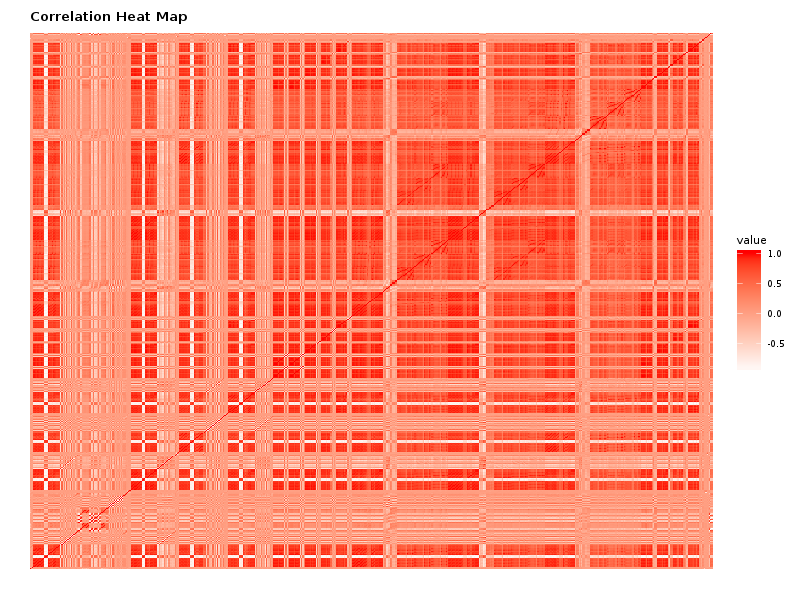

In [17]:
# correlation heat plot
train[, -c(1, 563), with = F] %>% 
  cor() %>% 
  melt() %>% 
  ggplot(aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
  labs(x = "", y = "", title = "Correlation Heat Map") +
  scale_fill_gradient(low = "white", high = "red") +
  theme(plot.title = element_text(lineheight = .8, face="bold"))

We can see quite clearly that there is infact highly correlated variables. This suggests that we most use a proper regularization while modeling.

We will now make a 3D scatter plot for the first 3 variables (`tBodyAccmeanX`, `tBodyAccmeanY`, `tBodyAccmeanZ`), and the response variable (`Activity`):

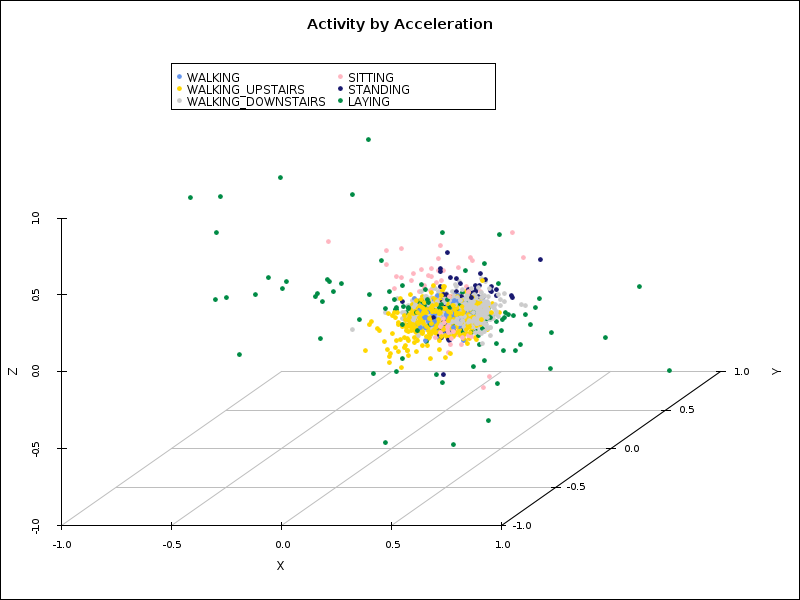

In [19]:
# # 3D plot
cex <- 1 # points size
colors <- c("cornflowerblue", "gold", "gray80", "lightpink", 
            "midnightblue", "springgreen4")
color <- colors[y.train$activity]
scatterplot3d(train[, 2:4, with = F], 
              pch = 16, color = color,
              main = "Activity by Acceleration",
              xlab = "X",
              ylab = "Y",
              zlab = "Z",
              grid = TRUE, 
              box = FALSE, 
              angle = 45,
              cex.symbols = cex)

# add legend
legend(x = -1, y = 4, legend = levels(y.train.vec),
       col = colors, ncol = 2, pch = 16, box.col = "black", cex = cex)

We can see that the response vector is slightly grouped, although the overlap between the different groups is quite big.

What about the first 3 components of the PCA?

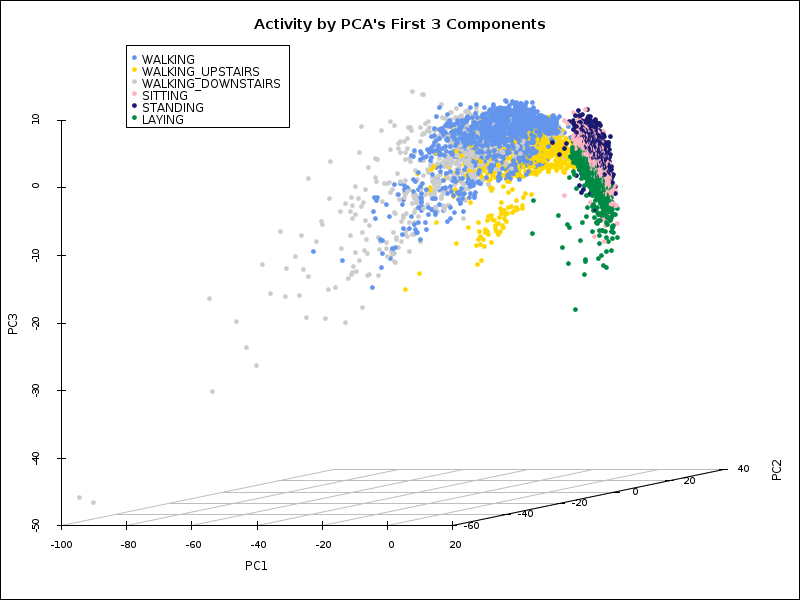

In [20]:
# # 3D plot
cex <- 1 # points size
colors <- c("cornflowerblue", "gold", "gray80", "lightpink", 
            "midnightblue", "springgreen4")
color <- colors[y.train$activity]
scatterplot3d(pca.train[, 1:3, with = F], 
              pch = 16, color = color,
              main = "Activity by PCA's First 3 Components",
              xlab = "PC1",
              ylab = "PC2",
              zlab = "PC3",
              grid = TRUE, 
              box = FALSE, 
              angle = 15,
              cex.symbols = cex)

# add legend
legend(x = -4, y = 2.1, legend = levels(y.train.vec),
       col = colors, ncol = 1, box.col = "black", pch = 16, cex = cex)

Nice!

<a name="Modeling"></a>

# Modeling

In this section we apply several classification algorithms to our training data, and estimate the models' accuracy on the test set.

We must remember that we are dealing with a huge amount of explanatory variables. This can highly effect the models' accuracy (over-fitting) and the algorithms run time. Hence, we will need to choose an appropriate models, or use a proper regularization. In addition, we will apply PCA, in order to reduce the dimension of the data, before appling some of the methods.

We will apply the following algorithms:

* k-NN 
* Random Forest
* GLM 

We will expect k-NN to perform poorly compare to other methods (curse of dimensionality - even with the PCA data), thus, k-NN results will set a benchmark which we hope to outperform.

<a name="k-NN"></a>

## k-NN

Choosing the number of nearest neighbors i.e. determining the value of k plays a significant role in determining the efficacy of the model. Thus, selection of k will determine how well the data can be utilized to generalize the results of the kNN algorithm. We will use Leave-One-Out Cross Validation (LOO-CV) in order to choose an appropriate k.

The model is applied to the PCA data.

In [21]:
# function to compute LOO-CV
cv.knn <- function(X, y, ks){
  train.acc <- rep(0, length(ks))
  for (i in 1:length(ks)){
    mod.pred <- knn.cv(X, y, k = ks[i])
    train.acc[i] <- mean(mod.pred == y) 
  }
  return(train.acc)
}

# run CV
ks <- c(1:5, 10, 20, 30)
set.seed(123)  # for reproducibility
X.pca.train.mat <- as.matrix(pca.train[, -c(103, 104), with = F]) 
train.acc <- cv.knn(X.pca.train.mat, y.train.vec, ks)

Let us look at the LOO-CV accuracy for the different $k$ values.

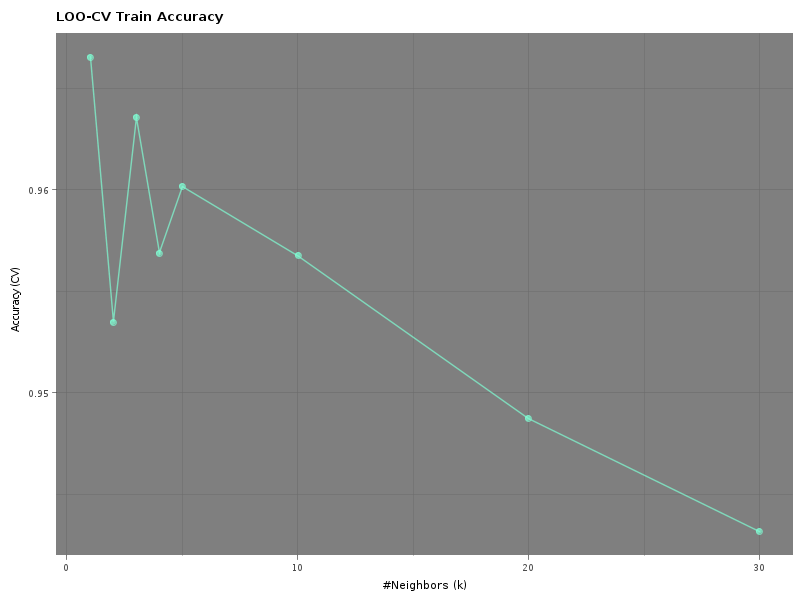

In [22]:
# plot CV results
to.plot <- data.table("k" = ks, "acc" = train.acc)
ggplot(aes(k, acc), data = to.plot) +
  geom_line(color = "aquamarine", alpha = 0.7) +
  geom_point(color = "aquamarine", alpha = 0.7) +
  labs(x = "#Neighbors (k)", y = "Accuracy (CV)") +
  ggtitle("LOO-CV Train Accuracy") +
  theme_dark() +
  theme(plot.title = element_text(lineheight = .8, face = "bold"))

According to above plot, $k=1$ is gives most accurate model. However, k-NN with $k=1$ tends to have high variance, thus we will try to use also $k=3$. Let us evalute the two model's accuracy on the test set.

In [23]:
X.pca.test.mat <- as.matrix(pca.test[, -c(103, 104), with = F])
# k-NN model with k=1,3
knn.pred.1 <- knn(X.pca.train.mat, X.pca.test.mat, y.train.vec, k = 1)
knn.pred.3 <- knn(X.pca.train.mat, X.pca.test.mat, y.train.vec, k = 3)

In [24]:
cat("The k=1 model's estimated accuracy is", round(mean(knn.pred.1 == y.test.vec) * 100, 2), 
    "%, while the one with $k=3$ gives", round(mean(knn.pred.3 == y.test.vec) * 100, 2), "%.")

The k=1 model's estimated accuracy is 84.32 %, while the one with $k=3$ gives 86.7 %.

As expected, the one with $k=3$ is more accurate.

<a name="Random Forest"></a>

## Random Forest

Random Forest (RF) model is highly compatible for large number of explanatory variables, and the randomness in the model (variables and observations) prevents us from overfittingthe model, even if we use a large number of trees.

We will build a model using 500 trees, and all explanatory variables. 

In [26]:
set.seed(123)  # for reproducibility
rf.fit <- randomForest(Activity ~ .-Subject, 
                            data = train, 
                            ntree = 500,        # number of trees 
                            importance = TRUE)  # compute variable importance

Let us look at the Out Of Bag (OOB) error. 

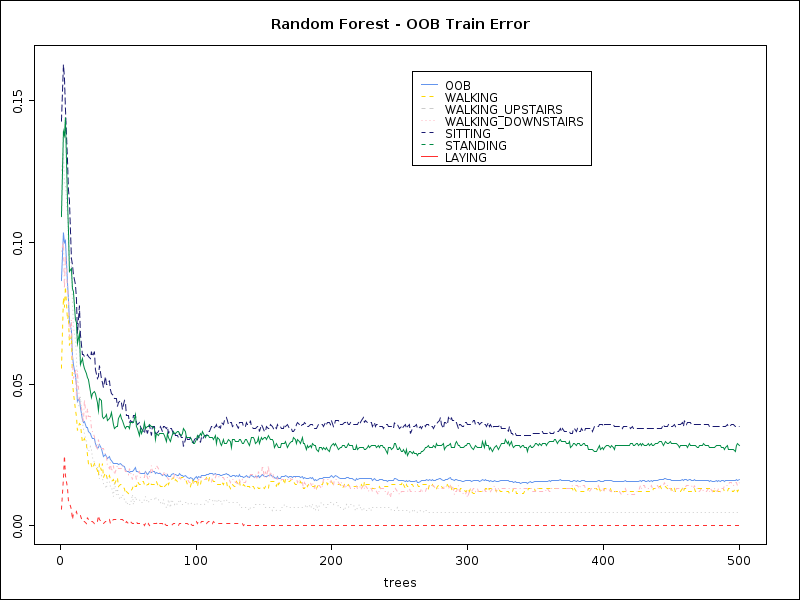

In [28]:
colors <- c("cornflowerblue", "gold", "gray80", "lightpink", 
            "midnightblue", "springgreen4")
plot(rf.fit, main = "Random Forest - OOB Train Error", 
     col = c(colors, "firebrick1"))
legend(x = 260, y = 0.16, legend = c("OOB", levels(y.test.vec)), 
       col = c(colors, "firebrick1"), lty = c(1, 2, 2, 3, 2, 2, 1))

It looks like the OOB error significant improvement stops after 100 trees. This suggests that we can use a model with ~100 trees, instead of 500. We will test to see if it is indeed correct.

In addition, we can look at the model's variable importance plot.

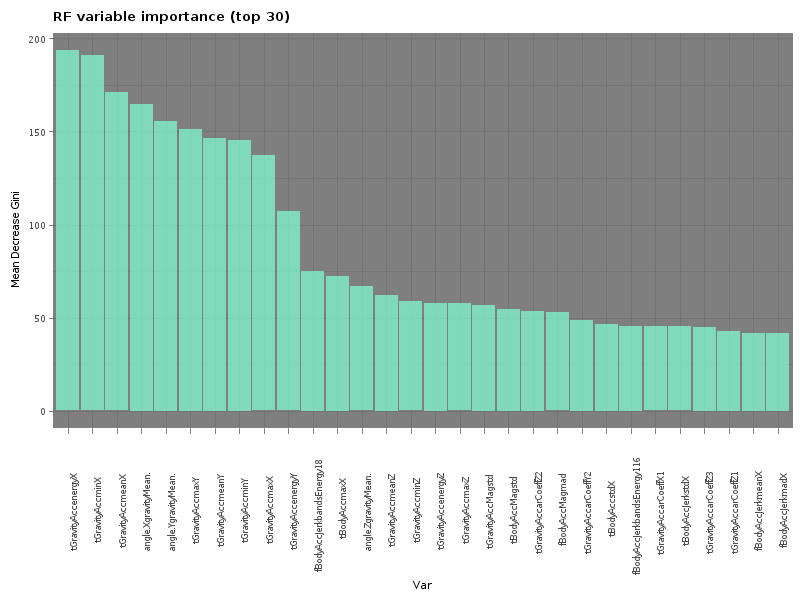

In [29]:
# variable importance df
rf.var.imp <- data.frame("var" = row.names(rf.fit$importance), 
                         "imp" = rf.fit$importance[, 8], 
                         row.names = NULL) %>%
                         arrange(desc(imp))
# add var order and labels
rf.var.imp$ord.vars <- gl(length(rf.var.imp$var), 1,
                          labels = rf.var.imp$var)

# plot num.var most important vars
num.var <- 30

ggplot(rf.var.imp[1:num.var,], aes(ord.vars, imp)) +
  geom_bar(stat = "identity", fill = "aquamarine", alpha = 0.7) +
  labs(title = paste("RF variable importance (top ", num.var, ")", sep = ''), 
       x = "Var", y = "Mean Decrease Gini") +
  theme_dark() +
  theme(axis.text.x = element_text(angle = 90),
        plot.title = element_text(lineheight = .8, face = "bold"))

Variable importance is computed using the mean decrease in Gini corresponding to a given variable. The above plot suggests that `tGravityAccenergyX`, `tGravityAccminX`, `tGravityAccmeanX` are the three most important variables. It is interesting to look at a 3D plot of those variables against the response:


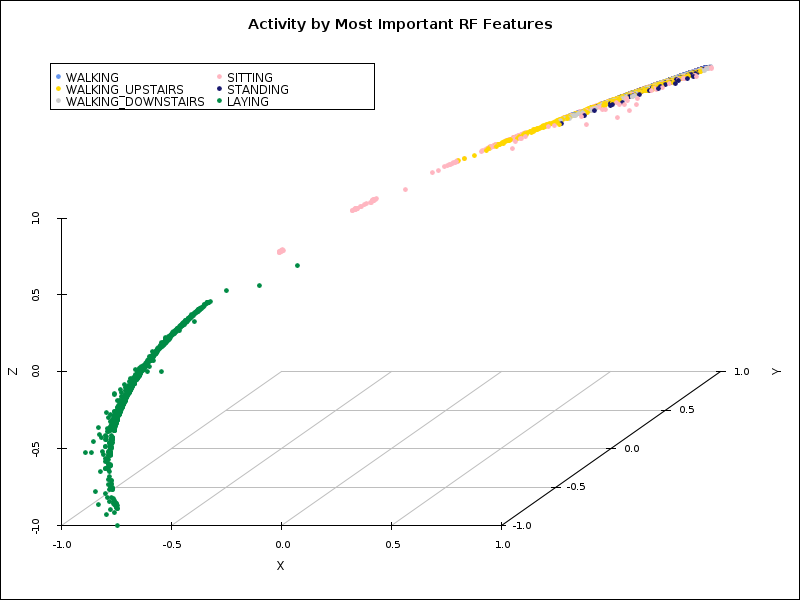

In [32]:
cex <- 1 # points size
colors <- c("cornflowerblue", "gold", "gray80", "lightpink", 
            "midnightblue", "springgreen4")
color <- colors[y.train$activity]
scatterplot3d(train[, as.character(rf.var.imp$var[1:3]), with = F], 
              pch = 16, color = color,
              main = "Activity by Most Important RF Features",
              xlab = "X",
              ylab = "Y",
              zlab = "Z",
              grid = TRUE, 
              box = FALSE, 
              angle = 45,
              cex.symbols = cex)

# add legend
legend(x = -2.1, y = 4, legend = levels(y.train.vec),
       col = colors, ncol = 2, pch = 16, box.col = "black", cex = cex)

Nice! 

Let us compute the model's accuracy on the test data.

In [33]:
rf.pred <- predict(rf.fit, newdata = test)

cat("The RF model's estimated accuracy (test set accuracy) is", 
    round(mean(rf.pred == y.test.vec) * 100, 2), "%")

The RF model's estimated accuracy (test set accuracy) is 92.64 %

Much better than the k-NN model's results, as expected. 

As promised, we will now try to use only 100 trees:

In [34]:
set.seed(123)  # for reproducibility
rf.fit.small <- randomForest(Activity ~ .-Subject, 
                            data = train, 
                            ntree = 100)

rf.small.pred <- predict(rf.fit.small, newdata = test)

cat("The model's accuracy is", round(mean(rf.small.pred == y.test.vec) * 100, 2), "%")

The model's accuracy is 92.64 %

The accuracy is practically the same as the one with 500 trees, but the model is much better in terms of run time.

can we get an even better results?

<a name="Generalized Linear Model"></a>

## Generalized Linear Model

Lastly, we will use GLM (with multinumial distribution), that is, we use the following setting:

Suppose we have $K$ groups for the response (6 in our case). Let $p_k=P(Y=k)$. We will use the following link function: $$\forall k=1,...,K-1, C(p_k)=\ln\frac{P(Y=k\mid X=x)}{P(Y=K\mid X=x)}=\beta_{0,k}+\beta_{1,k}x_1+...+\beta_{p,k}x_p=\beta_k^Tx$$Where $p$ is the number of predictors.

Using the fact that $\sum_{j=1}^{K-1} p_j=1-p_K$, we have $$P(Y=k\mid X=x)=\frac{\exp{\beta_kx}}{1+\sum_{j=1}^{K-1}\exp\{\beta_k^Tx\}}$$
For all $k=1,...,K-1$ and $$P(Y=K\mid X=x)=\frac{1}{1+\sum_{j=1}^{K-1}\exp\{\beta_k^Tx\}}$$
In addition, we will use lasso regularization, that is, we will maximize the log-likelihood function + penalty of the form $$\lambda \|\beta\|_1$$
The lasso penalty is known to set $\beta_i = 0$ whenever the corresponding predictor is irrelevant for the model, thus, naturally reduce the number of explanatory variables. This will result with a more accurate model, and lower run time.

In order to select the optimal $\lambda$ we will use cross validation.

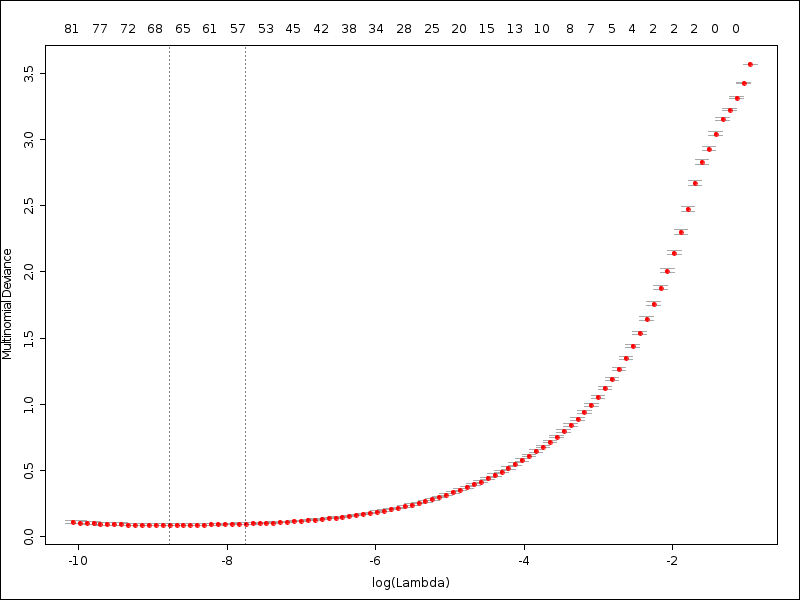

In [10]:
# X matrics for test and train
X.train.mat <- as.matrix(train[, -c(1, 563), with = FALSE])
X.test.mat <- as.matrix(test[, -c(1, 563), with = FALSE])

set.seed(123)  # for reproducibility
# CV in order to find 'best' lamnbda
# alpha = 1 - lasso only. Can blend with ridge down to alpha = 1
# ridge only.
cv.glm.mod <- cv.glmnet(X.train.mat, 
                        y.train.vec, 
                        alpha = 1, 
                        family = "multinomial")
# plot CV results
plot(cv.glm.mod)

best.lambda <- cv.glm.mod$lambda.min
p <- cv.glm.mod$glmnet.fit$df[cv.glm.mod$glmnet.fit$lambda == best.lambda]

In [11]:
cat("Minimal CV error is reached using lambda = ", round(best.lambda, 5),
    "We will use the corresponding model in order to give prediction 
    on the test set. This model is using", p, "predictors.")

Minimal CV error is reached using lambda =  0.00015 We will use the corresponding model in order to give prediction 
    on the test set. This model is using 220 predictors.

In [12]:
glm.pred <- predict(cv.glm.mod, newx = X.test.mat, 
                    s = "lambda.min", type = "class") 

In [13]:
cat("The model gives", round(mean(glm.pred == y.test.vec) * 100, 2), 
    "% accuracy.")

The model gives 95.18 % accuracy.

Not bad! The GLM model gives best test accuracy.

<a name="Conclusion"></a>

# Conclusion

To summarize the work done above, let us recall the different stages:

  + Download the data.
  + Create two data sets: one with original variables, and one with principal components (PCA).
  + Divide the two data sets into test and train.
  + Data visualisation in order to better understand the data.
  + Use predictive modeling in order to predict the target variable.
  
The main difficulty was the number of explanatory variables. It has tremendous effect on data analysis and model
selection:

For starters, data visualisation is highly limited. This not a huge problem but it does makes it diffecult to comprehance
the data in hand. In addition, proper regularization is advised if we wish to achieve high accuracy. That means the usage 
of dimensionality reduction techniques (e.g PCA), or the usage of appropriate models (e.g GLM + lasso penalty, RF etc.). 
This also decrease the model's interpretability possibilities (e.g statistical significance tests).

Given the above limitation, we chose the following models: k-NN (after PCA), Random Forest and GLM (+Lasso). 

The k-NN model's results were the most inaccurate, as expected (~86.7% accuracy on test data). 
This model is tend to performs quite badly at high dimensions (102 after PCA), 
thus we use the k-NN's accuracy as a benchmark for the other methods.

Next we tried to use RF. Here we didn't need to use any regularisation. Overfitting is canceled due to the
model's built-in randomness. In order to reduce run time we use 100 (instead of 500) trees, as suggested by the OOB 
error plot. RF gives ~92.6% accuracy on the test data.

Finally, we built a GLM model (with multinomial response). We used Lasso penalty for regularization, and CV for 
the estimation of the optimal lambda. The final model where consists of 220 predictors, and give ~95.1% accuracy
on test set. Not bad at all.

There are of course other models that can be tested in an attempt to further increase the accuracy 
(e.g Robust Regularized Linear Discriminant Analysis [RRLDA],  Gradient Boosting Machine [GBM], 
Deep Learning techniques, etc.). however, the overall results of our final model (GLM) are quite satisfying.

-------------------
<a name="myfootnote1">1</a>: The data is available at the UC Irvine Machine Learning Repository [(link to data)](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

<a name="myfootnote1">2</a>: Follow 
[this link](https://www.youtube.com/watch?v=XOEN9W05_4A&feature=youtu.be) 
or simply click on the above image to see a video of the 6 activities recorded in the experiment with one of the participants. 
